In [1]:
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:

def create_z():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(0.0))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image, scope, n_dim_z):
        with tf.variable_scope(scope):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
        return fully_connected_output
    
    with tf.variable_scope("model_params"):
        z = conv_and_fc(real_entire_tiled,"conv_1", n_dim_z1)
        #zs = conv_and_fc(scrambled_entire_tiled,"conv_2",n_dim_z2)
        zs = fc(tf.reshape(scrambled_entire_tiled,[batch_size,side*side]), n_dim_z2)
        #zz = tf.concat([z,zs],axis=1)
        z1 = tf.reshape(fc(z, n_squares*n_dim_z), [-1, n_squares, n_dim_z])
        z2 = tf.reshape(fc(zs, n_squares*n_dim_z), [-1, n_dim_z, n_squares])
        cost = tf.matmul(tf.sigmoid(z1),tf.nn.sigmoid(z2))
        #cost = tf.nn.sigmoid(tf.reshape(fc(z, n_squares*n_squares), [-1, n_squares,  n_squares]))
        
    return z,zs,cost

In [4]:
# Define model params
batch_size = 20
n_iter_sinkhorn2 = 10
n_iter_sinkhorn = 200

temp = 2.0
temp2 =0.001

#mnist data
n_squares_side = 16
lr = 0.0001
n_channels = 1
rfield_size = 3
stride = 3
n_units = 6
keep_prob = 1.0
side_real = 28
opt = 'adam'
samples_per_num = 1
n_squares = n_squares_side **2
n_gromov = 5
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)
print(n_dim)
n_dim_z = 128
n_dim_z1 = 10
n_dim_z2 = 64

noise_factor = 0
np.random.seed(2)

ims0,_=data_train.next_batch(1)
ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
ims0[ims0>0.5]=1
ims0[ims0<0.5]=0



nx = np.nansum(ims0) 
prop = nx/(side_real**2)*np.random.uniform(1.5,2.0)
pieces_split = np.zeros((batch_size, n_squares, side_square, side_square, 1))
for j in range(int(n_squares*prop)):
    pieces_split[:,j,:,:] = 1

scrambled_pieces_split = np.zeros(pieces_split.shape)



25


In [5]:
print(prop)

0.19335011239180147


In [6]:
#Now we define the main TF variables

scrambled_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
scrambled_split_tiled = tf.tile(scrambled_split, [samples_per_num, 1, 1, 1, 1])

stack_scrambled_pieces_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])

real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])

stack_real_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])

real_entire = tf.placeholder(tf.float32,[None, side_real, side_real, n_channels])
real_entire_tiled = tf.tile(real_entire,[samples_per_num,1,1,1])

scrambled_entire = tf.placeholder(tf.float32,[None, side, side, n_channels])
scrambled_entire_tiled = tf.tile(scrambled_entire,[samples_per_num,1,1,1])

temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)



In [7]:

scrambled_split_tiled = tf.reshape(scrambled_split_tiled, [-1, n_squares, side_square ** 2* n_channels])
real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2* n_channels])

#ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)

z,z2, cost= create_z()
(soft_perms_inf2, _) = sinkhorn_ops.gumbel_sinkhorn(-cost, temp2, samples_per_num, noise_factor, n_iter_sinkhorn2, squeeze=False)
inv_soft_perms2 = tf.transpose(soft_perms_inf2, [0, 1, 3, 2])
inv_soft_perms2_flat = tf.reshape(tf.transpose(inv_soft_perms2, [1, 0, 2, 3]), [-1, n_squares, n_squares])

ordered_inf2 = tf.matmul(inv_soft_perms2_flat, scrambled_split_tiled)
 

l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))
#l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))

opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [8]:
nperms = 200
perms = np.zeros((nperms, n_squares))
for k in range(nperms):
    perms[k,:] = np.random.permutation(n_squares)
from copy import deepcopy
init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
new = tf.trainable_variables()
print(new)
n_iter = 20000

for i in range(n_iter):
    

    ims0,_=data_train.next_batch(batch_size)
    ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
    ims0[ims0>0.5]=1
    ims0[ims0<0.5]=0



    
    pieces_split = np.zeros((batch_size, n_squares, side_square, side_square, 1))
    scrambled_pieces_split = np.zeros(pieces_split.shape)

    
    for j in range(batch_size):
        nx = np.nansum(ims0[j,:,:,:]) 
        prop = nx/(side_real**2)*np.random.uniform(1.0,1.0)
    
        for k in range(int(n_squares*prop)):
            pieces_split[j,k,:,:] = 1
        perm = np.random.permutation(n_squares)
        #perm = np.arange(n_squares)
        #perm = perms[np.random.choice(nperms,1),:][0,:].astype(int)
        scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm, :, :])
        #scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm[0,:].astype(int), :, :])
        
    stacked_scrambled_pieces_split = stack_batch_split(scrambled_pieces_split)
    ims_scrambled = join_batch_split(scrambled_pieces_split)

    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    stacked_real_images_split = stack_batch_split(real_images_split)

    [o2,loss, _, sp2,cos,z2n] = sess.run([ordered_inf2, l2s_diff, train_op, soft_perms_inf2,cost,scrambled_entire],{real_split:real_images_split,
                                 scrambled_split:scrambled_pieces_split,
                                 stack_scrambled_pieces_split:stacked_scrambled_pieces_split,
                                                                                stack_real_images_split:stacked_real_images_split,
                                                                               real_entire:ims,
                                                                                         scrambled_entire:ims_scrambled})
    if(i%10==0):
        print([i, loss, int(n_squares*prop)])
 
    if i==n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    [zn] = sess.run([ordered_inf2, l2s_diff, train_op, soft_perms_inf2,cost,scrambled_entire],{
                                 scrambled_split:scrambled_pieces_split,
                                 stack_scrambled_pieces_split:stacked_scrambled_pieces_split})
  


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[<tf.Variable 'model_params/conv_1/weights:0' shape=(3, 3, 1, 6) dtype=float32_ref>, <tf.Variable 'model_params/conv_1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/weights:0' shape=(600, 10) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/weights:0' shape=(6400, 64) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/weights:0' shape=(10, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/biases:0' shape=(32768,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/weights:0' shape=(64, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/biases:0' shape=(32768,) dtype=float32_ref>]


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[0, 0.106065996, 20]
[10, 0.09478214, 16]
[20, 0.097969666, 42]
[30, 0.10092153, 29]
[40, 0.09429177, 13]
[50, 0.09906362, 12]
[60, 0.098357365, 25]
[70, 0.08810334, 23]
[80, 0.09641266, 32]
[90, 0.09085382, 35]
[100, 0.09097857, 41]
[110, 0.08971687, 51]
[120, 0.086210676, 25]
[130, 0.0843685, 24]
[140, 0.090623856, 34]
[150, 0.0809689, 20]
[160, 0.086214505, 29]
[170, 0.08099255, 40]
[180, 0.09092273, 17]
[190, 0.08228607, 26]
[200, 0.08204812, 6]
[210, 0.0971429, 26]
[220, 0.08247754, 31]
[230, 0.08473334, 24]
[240, 0.08855864, 25]
[250, 0.09216629, 20]
[260, 0.09020901, 36]
[270, 0.08216405, 54]
[280, 0.07857454, 36]
[290, 0.088526756, 35]
[300, 0.08922995, 30]
[310, 0.0867518, 21]
[320, 0.08518094, 28]
[330, 0.085961625, 22]
[340, 0.08571493, 20]
[350, 0.08272203, 52]
[360, 0.08274869, 48]
[370, 0.08853342, 23]
[380, 0.08378287, 30]
[390, 0.08724079, 27]
[400, 0.085195705, 29]
[410, 0.08076683, 19]
[420, 0.09073778, 33]
[430, 0.08578208, 42]
[440, 0.0916918, 19]
[450, 0.0858181, 2

[3590, 0.07519176, 47]
[3600, 0.06613248, 55]
[3610, 0.075949594, 42]
[3620, 0.08296991, 29]
[3630, 0.07677688, 39]
[3640, 0.075328246, 17]
[3650, 0.08152327, 39]
[3660, 0.07401359, 29]
[3670, 0.06875756, 22]
[3680, 0.07149897, 36]
[3690, 0.079348475, 36]
[3700, 0.076359734, 25]
[3710, 0.075379886, 35]
[3720, 0.068521455, 36]
[3730, 0.078611106, 44]
[3740, 0.07693135, 35]
[3750, 0.083777085, 42]
[3760, 0.06388616, 39]
[3770, 0.07309145, 20]
[3780, 0.075074136, 22]
[3790, 0.07836912, 49]
[3800, 0.07826323, 40]
[3810, 0.07189586, 31]
[3820, 0.07104792, 60]
[3830, 0.08334384, 27]
[3840, 0.07790653, 37]
[3850, 0.06608669, 45]
[3860, 0.06698645, 41]
[3870, 0.08431283, 42]
[3880, 0.08105522, 28]
[3890, 0.07780749, 52]
[3900, 0.07270966, 38]
[3910, 0.078768425, 33]
[3920, 0.07982346, 22]
[3930, 0.071157865, 35]
[3940, 0.07764456, 47]
[3950, 0.065647505, 28]
[3960, 0.07286972, 26]
[3970, 0.07382523, 19]
[3980, 0.079308, 42]
[3990, 0.08870138, 57]
[4000, 0.07061945, 11]
[4010, 0.07761093, 54]
[

[7120, 0.055181663, 58]
[7130, 0.061582036, 42]
[7140, 0.054673254, 21]
[7150, 0.05873857, 34]
[7160, 0.06203643, 43]
[7170, 0.05951577, 46]
[7180, 0.06445931, 53]
[7190, 0.059138328, 30]
[7200, 0.06285069, 24]
[7210, 0.054240543, 31]
[7220, 0.06107775, 37]
[7230, 0.05751749, 57]
[7240, 0.06288318, 17]
[7250, 0.06596236, 49]
[7260, 0.06033735, 15]
[7270, 0.06521315, 22]
[7280, 0.0557521, 26]
[7290, 0.0574975, 45]
[7300, 0.06830194, 66]
[7310, 0.06252761, 39]
[7320, 0.060678005, 46]
[7330, 0.053785134, 32]
[7340, 0.054204974, 38]
[7350, 0.064903565, 43]
[7360, 0.054644085, 41]
[7370, 0.06121305, 40]
[7380, 0.064040266, 14]
[7390, 0.056443475, 40]
[7400, 0.057096146, 28]
[7410, 0.062147807, 47]
[7420, 0.052509133, 30]
[7430, 0.057534516, 16]
[7440, 0.058571275, 40]
[7450, 0.052251667, 38]
[7460, 0.057701517, 40]
[7470, 0.05995651, 34]
[7480, 0.052687302, 36]
[7490, 0.054865178, 29]
[7500, 0.05812308, 24]
[7510, 0.05602345, 18]
[7520, 0.054421578, 28]
[7530, 0.052355237, 33]
[7540, 0.0539

[10580, 0.04337163, 22]
[10590, 0.04813642, 29]
[10600, 0.04450389, 32]
[10610, 0.04337208, 35]
[10620, 0.04796613, 53]
[10630, 0.046520498, 40]
[10640, 0.04612276, 25]
[10650, 0.041165262, 46]
[10660, 0.048521023, 39]
[10670, 0.047465112, 38]
[10680, 0.04078062, 33]
[10690, 0.053000793, 17]
[10700, 0.044455063, 20]
[10710, 0.050957378, 35]
[10720, 0.04290936, 18]
[10730, 0.045512825, 44]
[10740, 0.042930014, 26]
[10750, 0.05077232, 37]
[10760, 0.04666751, 38]
[10770, 0.0443808, 28]
[10780, 0.04256295, 32]
[10790, 0.050739642, 41]
[10800, 0.050338164, 57]
[10810, 0.050012995, 26]
[10820, 0.049643237, 36]
[10830, 0.04923171, 30]
[10840, 0.041316018, 39]
[10850, 0.037955824, 28]
[10860, 0.047838524, 32]
[10870, 0.043046538, 48]
[10880, 0.048822638, 34]
[10890, 0.041943785, 34]
[10900, 0.045849647, 32]
[10910, 0.05186192, 29]
[10920, 0.051605385, 43]
[10930, 0.04749791, 52]
[10940, 0.049898572, 30]
[10950, 0.050324578, 40]
[10960, 0.048011906, 20]
[10970, 0.0434194, 41]
[10980, 0.04705897

[13930, 0.038909577, 32]
[13940, 0.046068992, 28]
[13950, 0.044535052, 34]
[13960, 0.041907493, 18]
[13970, 0.047605146, 23]
[13980, 0.04242613, 21]
[13990, 0.042555656, 23]
[14000, 0.043064706, 13]
[14010, 0.04470769, 16]
[14020, 0.04460095, 35]
[14030, 0.036705725, 48]
[14040, 0.04384378, 48]
[14050, 0.04286812, 27]
[14060, 0.040578727, 26]
[14070, 0.044066027, 23]
[14080, 0.047248673, 51]
[14090, 0.037521522, 31]
[14100, 0.047670588, 56]
[14110, 0.045296192, 46]
[14120, 0.042352263, 20]
[14130, 0.044520997, 31]
[14140, 0.04311536, 40]
[14150, 0.043631464, 51]
[14160, 0.04508135, 19]
[14170, 0.046818197, 39]
[14180, 0.042210285, 8]
[14190, 0.043621536, 29]
[14200, 0.03898095, 26]
[14210, 0.035416637, 29]
[14220, 0.045407593, 23]
[14230, 0.039420616, 14]
[14240, 0.041117776, 26]
[14250, 0.040892493, 48]
[14260, 0.0368791, 35]
[14270, 0.04372978, 26]
[14280, 0.039780356, 22]
[14290, 0.040768836, 32]
[14300, 0.03831163, 32]
[14310, 0.044586945, 33]
[14320, 0.04221165, 32]
[14330, 0.0467

[17270, 0.04015426, 18]
[17280, 0.046647094, 58]
[17290, 0.038289644, 46]
[17300, 0.047195297, 24]
[17310, 0.040972043, 39]
[17320, 0.04176087, 35]
[17330, 0.041368768, 22]
[17340, 0.03941881, 22]
[17350, 0.04529681, 31]
[17360, 0.04872001, 38]
[17370, 0.040938724, 26]
[17380, 0.033359747, 35]
[17390, 0.03858776, 52]
[17400, 0.038054176, 35]
[17410, 0.041250512, 48]
[17420, 0.042892944, 16]
[17430, 0.04144139, 19]
[17440, 0.03803354, 40]
[17450, 0.042767197, 36]
[17460, 0.039852913, 33]
[17470, 0.041014306, 34]
[17480, 0.044122193, 36]
[17490, 0.04343683, 28]
[17500, 0.04665252, 42]
[17510, 0.03861319, 57]
[17520, 0.046111412, 31]
[17530, 0.04638586, 53]
[17540, 0.045151904, 42]
[17550, 0.043907464, 30]
[17560, 0.043682117, 35]
[17570, 0.04749021, 33]
[17580, 0.038963486, 33]
[17590, 0.043903403, 13]
[17600, 0.0422223, 36]
[17610, 0.04254174, 61]
[17620, 0.039582927, 34]
[17630, 0.038635246, 18]
[17640, 0.042982552, 37]
[17650, 0.040819783, 51]
[17660, 0.044302985, 36]
[17670, 0.040595

In [16]:
nperms = 200
perms = np.zeros((nperms, n_squares))
for k in range(nperms):
    perms[k,:] = np.random.permutation(n_squares)
from copy import deepcopy
init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()


print(new)
n_iter = 2

for i in range(n_iter):
    

    ims0,_=data_train.next_batch(batch_size)
    ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
    ims0[ims0>0.5]=1
    ims0[ims0<0.5]=0



    
    pieces_split = np.zeros((batch_size, n_squares, side_square, side_square, 1))
    scrambled_pieces_split = np.zeros(pieces_split.shape)

    
    for j in range(batch_size):
        nx = np.nansum(ims0[j,:,:,:]) 
        prop = nx/(side_real**2)*np.random.uniform(1.0,1.0)
    
        for k in range(int(n_squares*prop)):
            pieces_split[j,k,:,:] = 1
        perm = np.random.permutation(n_squares)
        #perm = np.arange(n_squares)
        #perm = perms[np.random.choice(nperms,1),:][0,:].astype(int)
        scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm, :, :])
        #scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm[0,:].astype(int), :, :])
        
    stacked_scrambled_pieces_split = stack_batch_split(scrambled_pieces_split)
    ims_scrambled = join_batch_split(scrambled_pieces_split)

    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    stacked_real_images_split = stack_batch_split(real_images_split)

    [o2,loss, _, sp2,cos,z2n] = sess.run([ordered_inf2, l2s_diff, train_op, soft_perms_inf2,cost,scrambled_entire],{real_split:real_images_split,
                                 scrambled_split:scrambled_pieces_split,
                                 stack_scrambled_pieces_split:stacked_scrambled_pieces_split,
                                                                                stack_real_images_split:stacked_real_images_split,
                                                                               real_entire:ims,
                                                                                         scrambled_entire:ims_scrambled})
    if(i%10==0):
        print([i, loss, int(n_squares*prop)])
 
   


[<tf.Variable 'model_params/conv_1/weights:0' shape=(3, 3, 1, 6) dtype=float32_ref>, <tf.Variable 'model_params/conv_1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/weights:0' shape=(600, 10) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/weights:0' shape=(6400, 64) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/weights:0' shape=(10, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/biases:0' shape=(32768,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/weights:0' shape=(64, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/biases:0' shape=(32768,) dtype=float32_ref>]


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


FailedPreconditionError: Attempting to use uninitialized value model_params/conv_1/biases
	 [[node model_params/conv_1/biases/read (defined at <ipython-input-3-98330c04e3da>:12) ]]

Original stack trace for u'model_params/conv_1/biases/read':
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tornado/ioloop.py", line 1017, in start
    self._run_callback(self._callbacks.popleft())
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 542, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-32c16c69d6f8>", line 7, in <module>
    z,z2, cost= create_z()
  File "<ipython-input-3-98330c04e3da>", line 30, in create_z
    z = conv_and_fc(real_entire_tiled,"conv_1", n_dim_z1)
  File "<ipython-input-3-98330c04e3da>", line 24, in conv_and_fc
    conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
  File "<ipython-input-3-98330c04e3da>", line 12, in conv
    initializer=tf.constant_initializer(0.0))
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 562, in get_variable
    aggregation=aggregation)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
batch_size_display = batch_size
hard = np.zeros(sp2.shape)

for i in range(batch_size_display):
    hard[i,0,:,:] =soft_to_hard(np.transpose(sp2[i,0,:,:]))
unscrambled_images_hard =  np.matmul(hard[:,0,:,:], np.reshape(scrambled_pieces_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
unscrambled_images_soft =  o2
unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
joined_inf_hard = join_batch_split(unflatten_inf_hard)
unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
joined_inf_soft = join_batch_split(unflatten_inf_soft)


In [ ]:
fig,ax=plt.subplots(10,3,figsize=(10,30))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)
for i in range(10):
    
    ax[i,0].imshow(np_x[i,:,:,0],'gray')
    ax[i,1].imshow(joined_inf_hard[i,:,:,0],'gray')
    ax[i,2].imshow(joined_inf_soft[i,:,:,0],'gray')
    for k in range(3):
        ax[i,k].get_xaxis().set_visible(False)
        ax[i,k].get_yaxis().set_visible(False)

[ 0.2400106   0.21536942  0.21986265  0.7991353   0.20619056  0.22046894
  0.1817272   0.21426418  1.1261232   0.2096788   0.9240097   1.0376089
  0.21987295  0.21425708  1.1934347   0.2058645   0.7895332   0.39344308
  0.21241829  0.21472213  0.21560258  1.8109412   1.6472311   1.1147888
  1.0385557   0.93242776  0.9589306   0.21258591 57.026295    0.21111092
  0.37705278  0.85082096  0.25223076  0.22991873  0.50294733  0.2473779
  1.4993777   0.3119607   0.21266255  3.1231017   1.1138241   0.2691
  0.2212405   0.26947325  2.0364776   2.1323907   0.21964726  0.21915665
  0.22146297  0.21786061  0.57256234  1.1132381   1.1469754   0.21559069
  1.1082351   0.50853705  1.0822182   0.22180966  2.5953293   1.0483315
  0.22160375  0.27834976  0.23935074  0.21262231  0.21733996  0.2151301
  0.21101929  0.21649782  1.0451044   1.7182908   0.39903718  0.31837088
  0.48709393  0.99647725  1.0241269   1.5886372   0.63214976  1.065808
  0.24226713  0.76140267  1.8020871   6.491647    0.8686061   

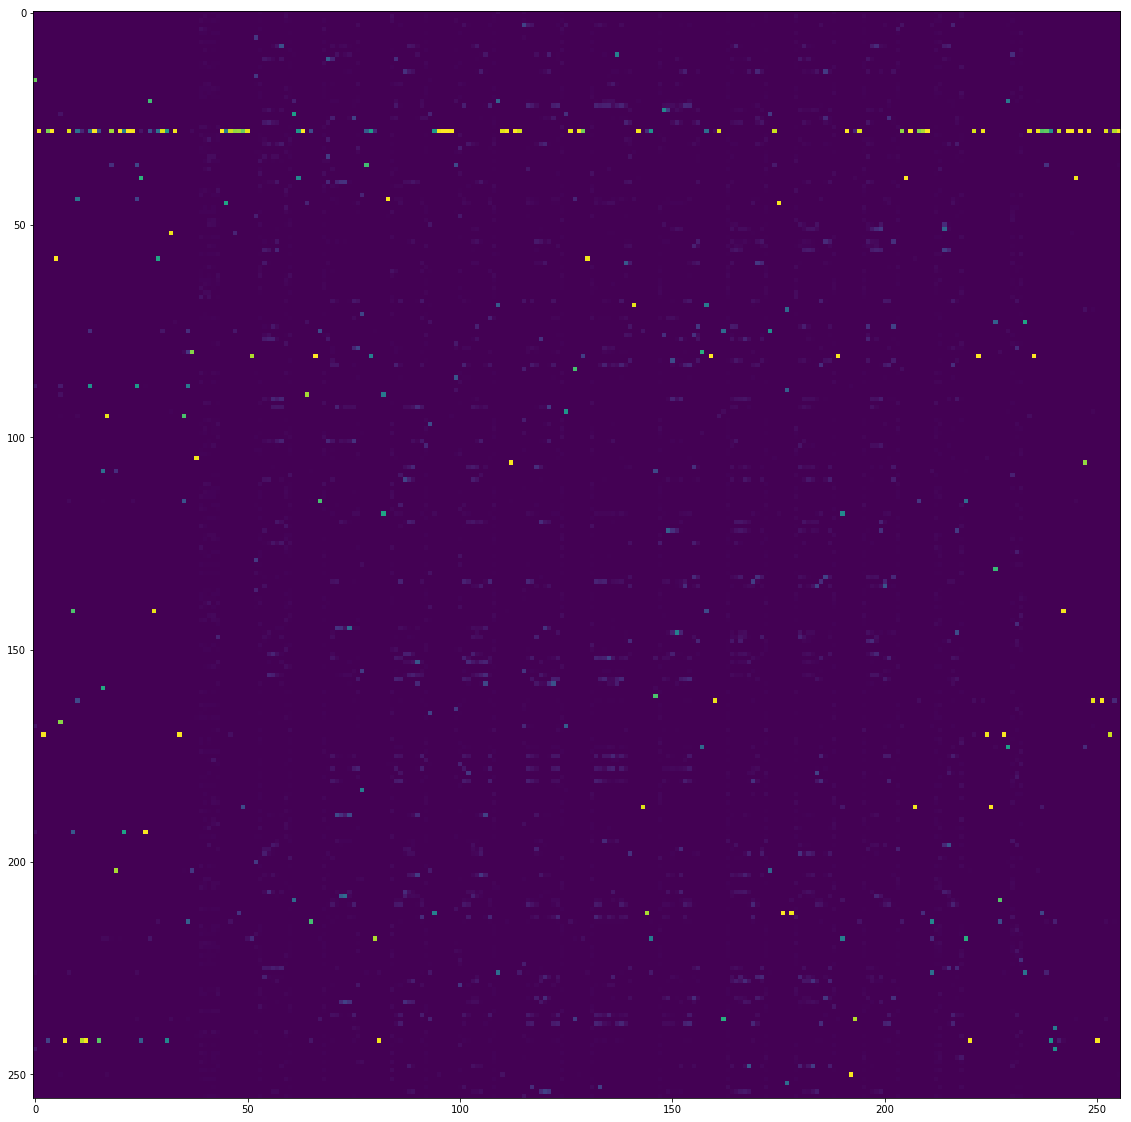

In [11]:
print(np.sum(sp2[0,0,:,:], axis=1))
plt.figure(figsize=(20,20))
plt.imshow(sp2[0,0,:,:])

8.78188775510204


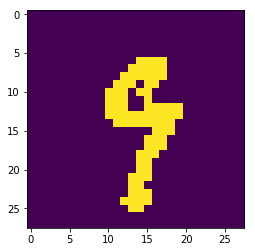

In [12]:

ims0,_=data_train.next_batch(1)
ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
ims0[ims0>0.5]=1
ims0[ims0<0.5]=0

print(81*np.nansum(ims0)/784)
plt.imshow(ims0[0,:,:,0])


In [13]:
#Now we define the main TF variables
print(nx)

# data_pieces = tf.reshape(stack_scrambled_pieces_split, [batch_size, n_squares, n_dim])
# data_real = tf.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])


# sq = tf.reduce_sum(data_pieces **2, axis=2, keepdims=True)
# A = tf.tile(sq, [1, 1, n_squares])
# B = tf.tile(tf.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
# C = -2*tf.matmul(data_pieces, tf.transpose(data_pieces, [0, 2, 1]))
# s1 = A+B +C

# sq2 = tf.reduce_sum(data_real **2, axis=2, keepdims=True)
# A2 = tf.tile(sq2, [1, 1, n_squares])
# B2 = tf.tile(tf.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
# C2 = -2*tf.matmul(data_real, tf.transpose(data_real, [0, 2, 1]))
# s2 = A2+B2 +C2


# f1 = tf.tile(tf.reduce_sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
# f2 = tf.transpose(tf.tile(tf.reduce_sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
# soft_perms_inf = tf.cast(tf.tile(tf.constant(np.eye(n_squares))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)
  
    
# for _ in range(n_gromov):
#     P = tf.reshape(soft_perms_inf, [-1, n_squares, n_squares])      
#     ma = -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P, s2)))
#     (soft_perms_inf, _) = sinkhorn_ops.gumbel_sinkhorn(ma, temp, samples_per_num,
#                                                                        noise_factor, n_iter_sinkhorn, squeeze=False)

#inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
#inv_soft_perms_flat = tf.reshape( tf.transpose(inv_soft_perms, [1, 0, 2, 3]), [-1, n_squares, n_squares])

113.0


In [14]:
plt.imshow()

TypeError: imshow() takes at least 1 argument (0 given)

In [ ]:

nx = np.nansum(ims0) 
prop = nx/(side**2)
print(prop)

In [ ]:
plt.imshow(ims0[0,:,:,0])

In [ ]:
int(n_squares*prop)

In [ ]:
print(side)

In [ ]:
np.random.seed(1)
perm = np.random.permutation(n_squares)
print(perm)